In [1]:
!ml cuda/10.2.89.440
from faimed3d.all import *
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn
from IPython.display import display, HTML
from glob import glob
import os

/clusterdata/uqaste15/.local/lib/python3.8/site-packages/torch-1.7.0-py3.8-linux-x86_64.egg/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
qsm_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*qsm.nii*"))
seg_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*segmentation_clean_seeds.nii*")) # TODO: Add calcifications
t2s_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*t2starmap.nii*"))
mag_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*magnitude_combined.nii*"))
assert(len(qsm_files) == len(seg_files) == len(t2s_files) == len(mag_files))
print(f"{len(qsm_files)} samples found in data/bids.")

10 samples found in data/bids.


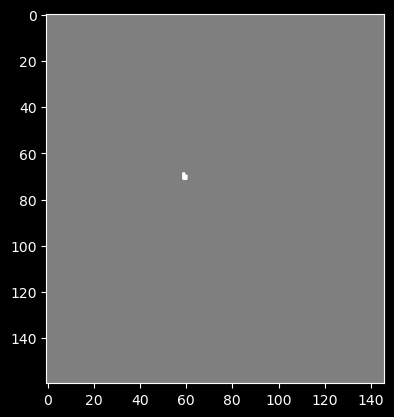

In [44]:
import nibabel as nib
import numpy as np
from matplotlib.pyplot import imshow
idx = 0
seg = nib.load(seg_files[idx]).get_fdata()
qsm = nib.load(qsm_files[idx]).get_fdata()
seg_indices = np.unique(np.where(seg > 0)[2])
qsm_samples = list(np.swapaxes(qsm[:,:,seg_indices], 0, 2))
seg_samples = list(np.swapaxes(seg[:,:,seg_indices], 0, 2))

In [3]:
# define input data
df = pd.DataFrame({
    'qsm'  : qsm_files,
    'masks': seg_files
})
display(df)

,qsm,masks
0,data/bids/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_qsm.nii,data/bids/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean_seeds.nii
1,data/bids/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_qsm.nii,data/bids/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_segmentation_clean_seeds.nii
2,data/bids/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_qsm.nii,data/bids/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_segmentation_clean_seeds.nii
3,data/bids/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_qsm.nii,data/bids/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_segmentation_clean_seeds.nii
4,data/bids/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_qsm.nii,data/bids/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_segmentation_clean_seeds.nii
5,data/bids/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_qsm.nii,data/bids/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_segmentation_clean_seeds.nii
6,data/bids/sub-z1778013/ses-20220715/extra_data/sub-z1778013_ses-20220715_run-01_qsm.nii,data/bids/sub-z1778013/ses-20220715/extra_data/sub-z1778013_ses-20220715_run-01_segmentation_clean_seeds.nii
7,data/bids/sub-z2007565/ses-20220715/extra_data/sub-z2007565_ses-20220715_run-01_qsm.nii,data/bids/sub-z2007565/ses-20220715/extra_data/sub-z2007565_ses-20220715_run-01_segmentation_clean_seeds.nii
8,data/bids/sub-z2980672/ses-20211020/extra_data/sub-z2980672_ses-20211020_run-01_qsm.nii,data/bids/sub-z2980672/ses-20211020/extra_data/sub-z2980672_ses-20211020_run-01_segmentation_clean_seeds.nii
9,data/bids/sub-z3278008/ses-20211109/extra_data/sub-z3278008_ses-20211109_run-01_qsm.nii,data/bids/sub-z3278008/ses-20211109/extra_data/sub-z3278008_ses-20211109_run-01_segmentation_clean_seeds.nii


In [4]:
# show some input data
TensorDicom3D.create(df.qsm[0]).show()
TensorDicom3D.create(df.masks[0]).show()

In [5]:
# dataloader
#  TODO: Optimisation -> 2D model may be faster and lower memory than 3D model - only include slices with seeds - this may even make more sense, and allow batch size to increase
#                     - ideally keep the same resolution for 2D
dls = SegmentationDataLoaders3D.from_df(
    df=df,    # dataframe
    path='.', # path to root data directory
    #item_tfms=ResizeCrop3D((0, 0, 0), (60, 160, 146)), # one or several transforms applied to the data before batching them
    item_tfms=ResizeCrop3D((0, 0, 0), (36, 96, 88)), # one or several transforms applied to the data before batching them
    #item_tfms=ResizeCrop3D((0, 0, 0), (50, 50, 50)), # one or several transforms applied to the data before batching them
    bs=2,     # how many samples per batch to load (overridden by batch_size if specified)
    val_bs=1, # batch size for validation (defaults to bs)
    splitter=RandomSplitter(valid_pct=0.2) # random split 20% / 80%
)

In [6]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) / (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [7]:
# build a unet learner from dls and arch
learn = unet_learner_3d(
    dls=dls,            # data loader
    arch=r3d_18,        # model architecture
    n_out=2,            # number of final filters (by default inferred from dls where possible)
    loss_func=loss,     # loss function for evaluation during training
    metrics=dice_score, # performance measure for humans (and model selection?)
    model_dir='models', # save directory for trained model
    cbs=[SaveModelCallback(monitor='dice_score', with_opt=True)] # saves the model's best during training and loads it at the end
)
learn = learn.to_fp16() # use half-precision floats for the learner

/clusterdata/uqaste15/.local/lib/python3.8/site-packages/faimed3d-0.0.6-py3.8.egg/faimed3d/basics.py:264: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Removing the first dimension
  warn('Object is not a rank 3 tensor but a rank {} tensor. Removing the first dimension'.format(t.ndim))


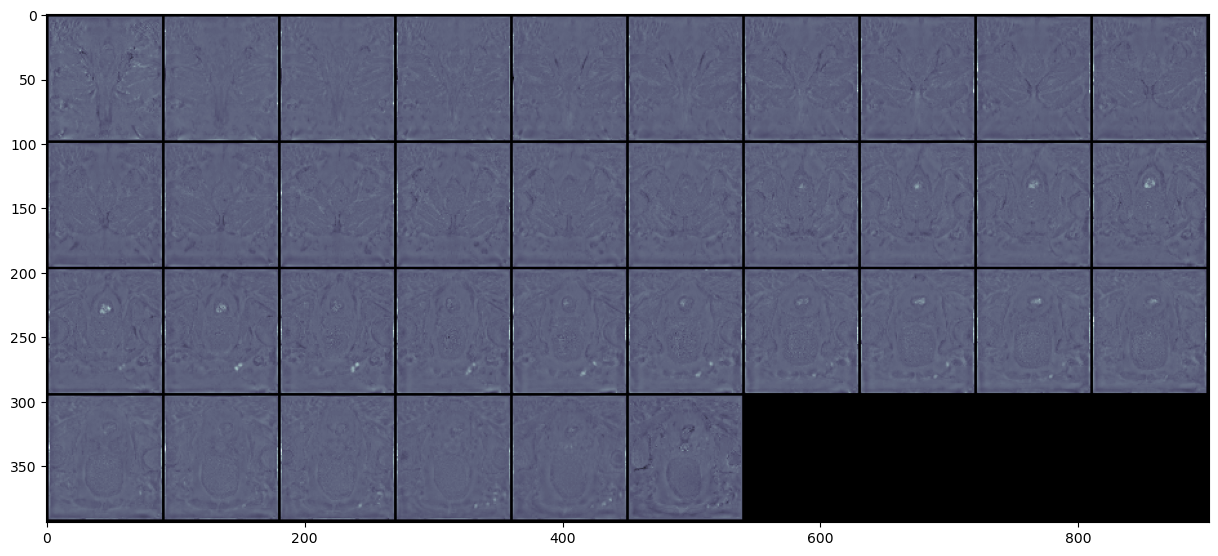

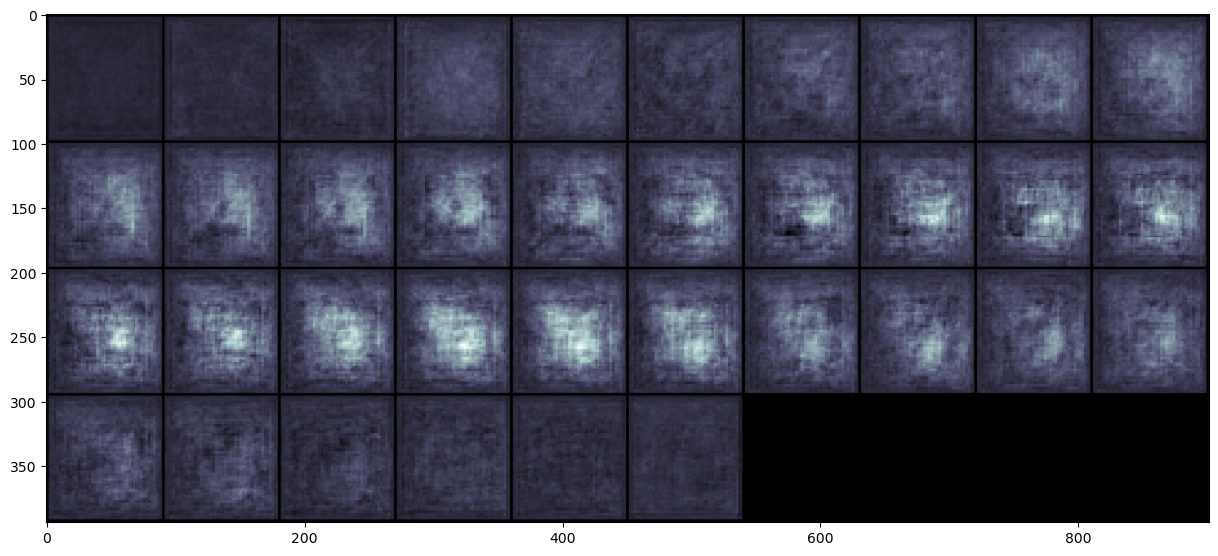

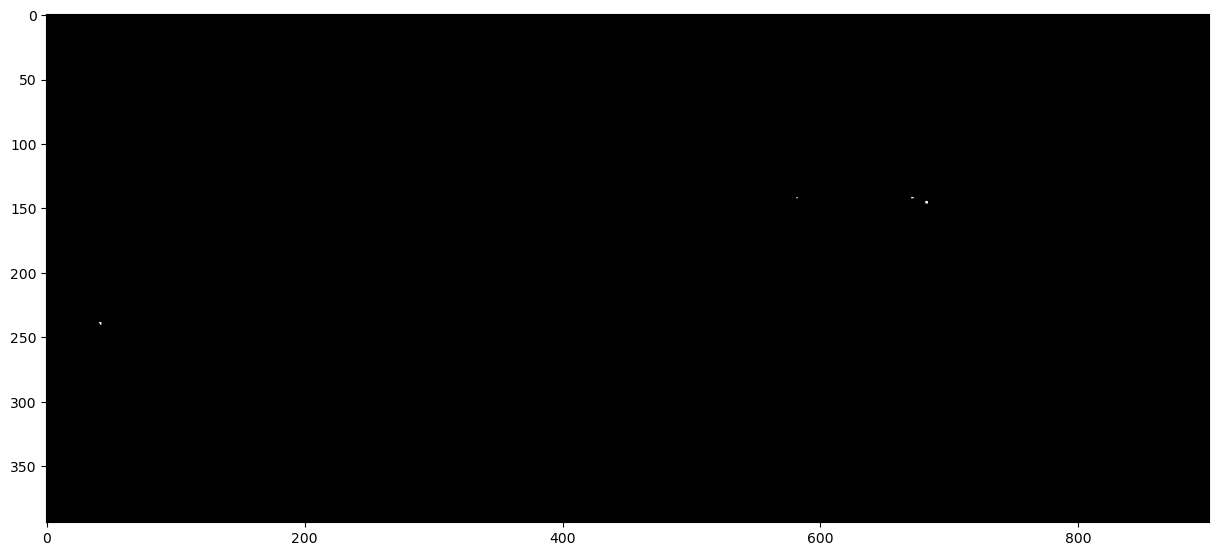

In [11]:
inp, pred, target = learn.get_preds(with_input = True)
show_image_3d(inp[1], axis = 0)
show_image_3d(pred[1], axis = 0)
show_image_3d(target[1], axis = 0)

In [14]:
#learn.load(os.path.abspath('models/model'))

In [31]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 298.00 MiB (GPU 0; 15.78 GiB total capacity; 14.25 GiB already allocated; 155.44 MiB free; 14.43 GiB reserved in total by PyTorch)

In [16]:
#learn.fit_one_cycle(n_epoch=3, lr_max=0.01, wd=1e-4)
learn.fit_one_cycle(
    n_epoch=300,
    lr_max=0.01,
    #wd=1e-4
)

epoch,train_loss,valid_loss,dice_score,time
0,1.749275,2.146349,0.000000,00:02
1,1.718964,1.579147,0.000000,00:01
2,1.708266,1.666711,0.000000,00:01
3,1.702446,1.679401,0.000000,00:01
4,1.698544,1.699376,0.000000,00:01
5,1.695559,1.693493,0.000000,00:01
6,1.693059,1.688713,0.000000,00:01
7,1.690821,1.685982,0.000000,00:01
8,1.688715,1.682621,0.000077,00:01
9,1.686657,1.678671,0.000087,00:01


Better model found at epoch 0 with dice_score value: 0.0.
Better model found at epoch 8 with dice_score value: 7.682557043153793e-05.
Better model found at epoch 9 with dice_score value: 8.705493382876739e-05.
Better model found at epoch 11 with dice_score value: 0.0002642824256327003.


KeyboardInterrupt: 

In [11]:
learn.unfreeze()
learn.fit_one_cycle(n_epoch=500, lr_max=1e-3, wd=1e-4)

epoch,train_loss,valid_loss,dice_score,time
0,1.692106,1.717023,0.000176,00:03
1,1.691768,1.664855,0.000000,00:03
2,1.691570,1.663615,0.000000,00:03
3,1.691417,1.670009,0.000000,00:03
4,1.691282,1.675564,0.000000,00:03
5,1.691156,1.678091,0.000000,00:03
6,1.691032,1.678979,0.000000,00:03
7,1.690907,1.679880,0.000000,00:03
8,1.690781,1.682132,0.000265,00:03
9,1.690652,1.685045,0.000286,00:03


Better model found at epoch 0 with dice_score value: 0.00017587745969649404.
Better model found at epoch 8 with dice_score value: 0.00026544020511209965.
Better model found at epoch 9 with dice_score value: 0.0002860181557480246.
Better model found at epoch 20 with dice_score value: 0.0003191180876456201.
Better model found at epoch 22 with dice_score value: 0.0004221837152726948.
Better model found at epoch 23 with dice_score value: 0.0005527440225705504.


In [12]:
dls = SegmentationDataLoaders3D.from_df(
    d, path = '.',
    item_tfms = ResizeCrop3D((0, 0, 0), (50, 50, 50)), 
    batch_tfms = [RandomPerspective3D(50, 0.5), 
    *aug_transforms_3d(p_all=0.5)],
    bs = 1, 
    val_bs = 1,
    splitter = ColSplitter('is_valid')
)

In [2]:
learn = learn.load('model')

NameError: name 'learn' is not defined

In [14]:
inp, pred, target = learn.get_preds(with_input = True)

<class 'faimed3d.basics.TensorDicom3D'>


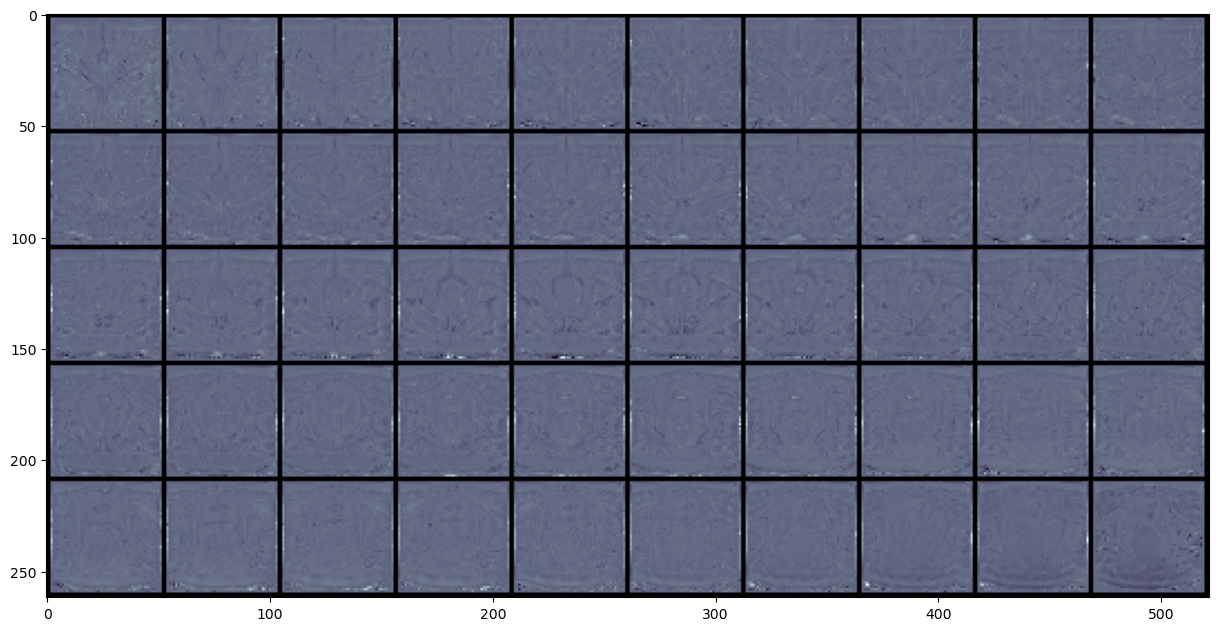

In [38]:
print(type(inp))
show_image_3d(inp[0], axis = 0, nrow = 10)
#inp.show(nrow=10, figsize = (30, 30))
#inp.show()

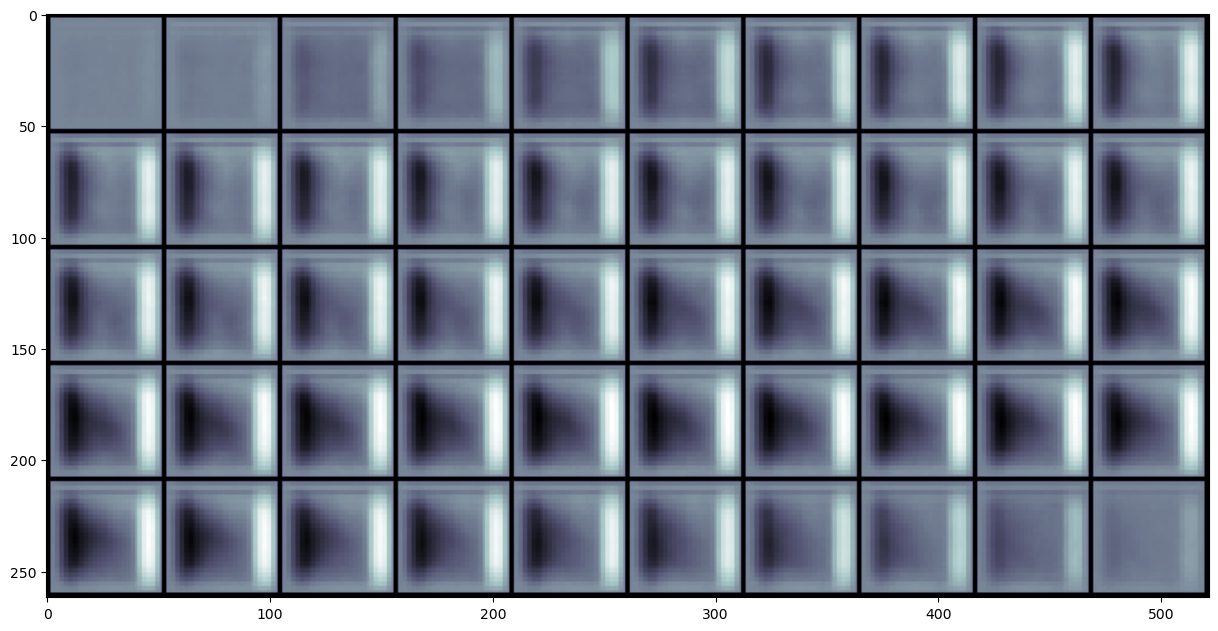

In [37]:
#pred.argmax(1).show(nrow=10, add_to_existing = True, alpha = 0.25, cmap = 'jet')
show_image_3d(pred[0], axis = 0, nrow = 10)

In [34]:
inp.show(nrow=10, figsize = (30, 30))

TypeError: __init__() got an unexpected keyword argument 'nrow'

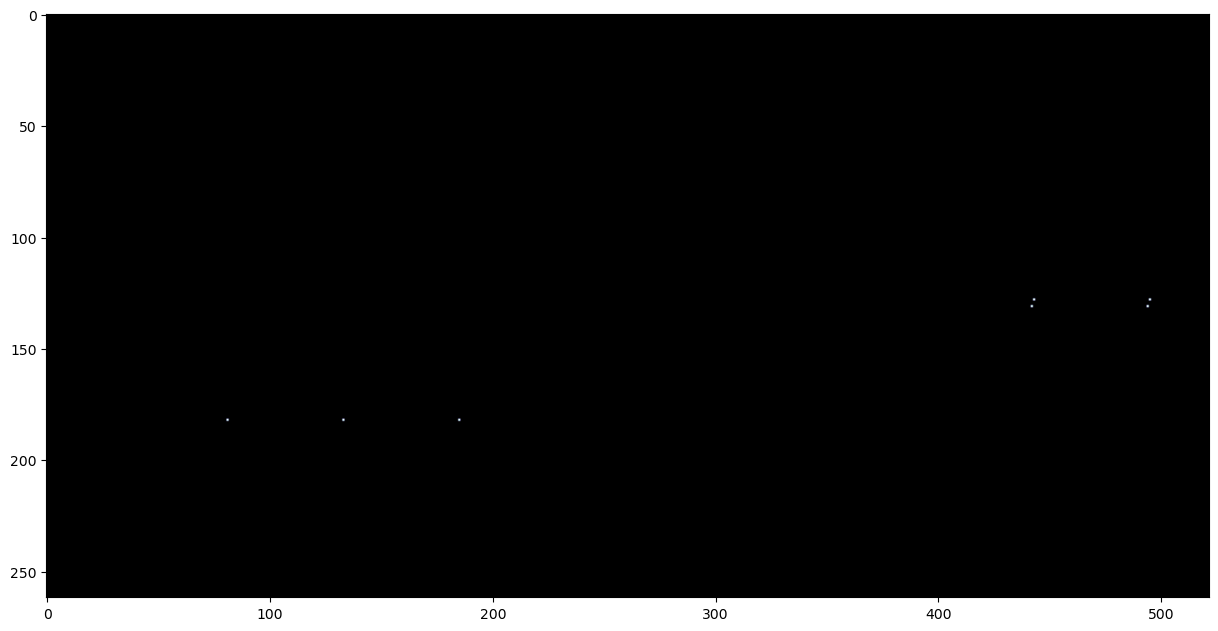

In [36]:
#target.show(nrow=10, add_to_existing = True, alpha = 0.25, cmap = 'jet')
show_image_3d(target[0], axis = 0, nrow = 10)

In [16]:
dice_score(pred, target)

tensor(0.0004)

In [17]:
TensorMask3D(0.7255)

TensorMask3D(0.7255)